In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = (11.5, 8.5)

### Point wise

In [6]:
events_data = pd.read_csv('movie_events_linear.csv')
events_data.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Thriller,War,Western,price,ratings_average,ratings_count,release_date,unknown,outcome,user_id
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.283637,0.169532,-0.142869,0.393978,0.0,0,534
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.283637,-0.097012,-0.715191,0.393978,0.0,1,686
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,-0.777083,-1.056570,-0.690307,0.253620,0.0,1,532
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.246723,-0.416864,-0.690307,0.393978,0.0,1,624
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.344357,1.138281,-0.379263,0.464156,0.0,0,577


In [9]:
events_data.release_date.min()

-4.729066794540959

In [7]:
events_data.columns

Index(['Action', 'Adventure', 'Animation', 'Children's', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'price',
       'ratings_average', 'ratings_count', 'release_date', 'unknown',
       'outcome', 'user_id'],
      dtype='object')

## Задание 0

Посчитайте число уникальных пользователей и среднее число фильмов на каждого в датасете

In [10]:
print(np.unique(events_data['user_id']).shape)

(999,)


In [11]:
print(events_data.shape[0] / np.unique(events_data['user_id']).shape[0])

20.0


## Задание 1

Разбейте выборку на train и test. Важно, чтобы все пользователи попали в трейн и тест.

In [13]:
X = events_data.drop('outcome', axis=1)
y = events_data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=13,
                                                    stratify=X['user_id'])

## Задание 2

Закодируйте признак `user_id` с помощью OHE.

Используйте `ColumnTransformer`.

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ("categ_prep", OneHotEncoder(), ['user_id'])
], remainder='passthrough')

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [22]:
X_train

<13986x1022 sparse matrix of type '<class 'numpy.float64'>'
	with 94066 stored elements in Compressed Sparse Row format>

In [16]:
column_transformer.get_feature_names()[:10]

['categ_prep__x0_1',
 'categ_prep__x0_2',
 'categ_prep__x0_3',
 'categ_prep__x0_4',
 'categ_prep__x0_5',
 'categ_prep__x0_6',
 'categ_prep__x0_7',
 'categ_prep__x0_8',
 'categ_prep__x0_9',
 'categ_prep__x0_10']

## Задание 3

Обучите логистическую регрессию.

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, penalty='l2')
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Задание 4

Сделайте предсказание для теста, измерьте качество с помощью Precision. 

In [18]:
from sklearn.metrics import precision_score

y_pred = lr.predict(X_test)

In [19]:
y_pred = lr.predict(X_test)
precision_score(y_test, y_pred)

0.6728731022629619

## Задание 5

Просчитайте precision для каждого пользователя отдельно и усредните

array([False, False, False, ..., False, False, False])

In [29]:
N_users = np.unique(events_data['user_id']).shape[0]
user_cols = X_test.toarray()[:, :N_users]

pr = []
for i in range(N_users):
    ids = np.where(user_cols[:, i] == 1)[0]
    pr.append(precision_score(y_test.values[ids], y_pred[ids], zero_division=0))
    
print(np.mean(pr))

0.674924924924925


## Задание 6

Для каждого пользователя выберете 3 самых 'уверенных' прогноза модели и посчитайте pr@3.

Вам пригодятся функции `np.where` и `np.argsort`

In [35]:
pr = []
y_pred_prob = lr.predict_proba(X_test)[:, 1]

for i in range(N_users):
    ids = np.where(user_cols[:, i] == 1)[0]
    ps = y_pred_prob[ids]
    most_confident = ids[np.argsort(ps)[-3:]]
    
    pr.append(precision_score(y_test.values[most_confident], y_pred[most_confident], zero_division=0))
    
print(np.mean(pr))

0.7092092092092092


---

# Pair wise

Используем данные о парах фильмах. Значение 1 целевой переменной означает, что был выбран фильм 1, а 0 - что фильм 2.

In [36]:
events_data = pd.read_csv('movie_events_pairwise-linear.csv')

In [37]:
events_data.head()

,Action_1,Adventure_1,Animation_1,Children's_1,Comedy_1,Crime_1,Documentary_1,Drama_1,Fantasy_1,Film-Noir_1,...,Thriller_2,War_2,Western_2,price_2,ratings_average_2,ratings_count_2,release_date_2,unknown_2,outcome,user_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.283637,-0.325478,-0.391705,0.604514,0.0,0.0,517.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.813997,0.268534,-0.478797,0.464156,0.0,1.0,155.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.777083,-0.378482,-0.117986,-1.430668,0.0,0.0,559.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.283637,0.060890,3.191525,0.534335,0.0,0.0,707.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,-2.368163,-2.655833,-0.727633,0.464156,0.0,0.0,73.0


In [153]:
events_data.columns

Index(['Action_1', 'Adventure_1', 'Animation_1', 'Children's_1', 'Comedy_1',
       'Crime_1', 'Documentary_1', 'Drama_1', 'Fantasy_1', 'Film-Noir_1',
       'Horror_1', 'Musical_1', 'Mystery_1', 'Romance_1', 'Sci-Fi_1',
       'Thriller_1', 'War_1', 'Western_1', 'price_1', 'ratings_average_1',
       'ratings_count_1', 'release_date_1', 'unknown_1', 'Action_2',
       'Adventure_2', 'Animation_2', 'Children's_2', 'Comedy_2', 'Crime_2',
       'Documentary_2', 'Drama_2', 'Fantasy_2', 'Film-Noir_2', 'Horror_2',
       'Musical_2', 'Mystery_2', 'Romance_2', 'Sci-Fi_2', 'Thriller_2',
       'War_2', 'Western_2', 'price_2', 'ratings_average_2', 'ratings_count_2',
       'release_date_2', 'unknown_2', 'outcome', 'user_id'],
      dtype='object')

In [38]:
events_data.shape

(130236, 48)

In [39]:
events_data['outcome'].value_counts()

1.0    65118
0.0    65118
Name: outcome, dtype: int64

In [40]:
print(np.unique(events_data['user_id']).shape)

print(events_data.shape[0]/np.unique(events_data['user_id']).shape[0])

(999,)
130.36636636636638


## Задание 7

Разбейте выборку на train и test, закодируйте переменную user_id.

In [41]:
X = events_data.drop('outcome', axis=1)
y = events_data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=13,
                                                    stratify=X['user_id'])

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((91165, 47), (39071, 47), (91165,), (39071,))

In [43]:
column_transformer = ColumnTransformer([
    ("categ_prep", OneHotEncoder(), ['user_id'])
], remainder='passthrough')

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

## Задание 8

Обучите логистическую регрессию.

In [45]:
model0 = LogisticRegression(random_state=13, max_iter=2000)

model0.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=13)

## Задание 9

Сделайте предсказание для теста, измерьте качество с помощью метрик из предыдущей части. Сравните результат.

In [47]:
y_pred = model0.predict(X_test)
precision_score(y_test, y_pred)

0.7133790561981779

In [48]:
N_users = np.unique(events_data['user_id']).shape[0]
user_cols = X_test.toarray()[:, :N_users]

pr = []
for i in range(N_users):
    ids = np.where(user_cols[:, i] == 1)[0]
    pr.append(precision_score(y_test.values[ids], y_pred[ids], zero_division=0))
    
print(np.mean(pr))

0.7178277605714455


In [52]:
pr = []
y_pred_prob = model0.predict_proba(X_test)[:, 1]

for i in range(N_users):
    ids = np.where(user_cols[:, i] == 1)[0]
    ps = y_pred_prob[ids]
    most_confident = ids[np.argsort(ps)[-3:]]
    
    pr.append(precision_score(y_test.values[most_confident], y_pred[most_confident], zero_division=0))
    
print(np.mean(pr))

0.8643643643643644


## Задание 10

Выведите важности признаков (`model0.coef_`)

In [57]:
model0.coef_[0]

array([-0.06316484,  0.1909696 ,  0.12014521, ..., -0.06384117,
        0.31162572, -0.95038361])

In [58]:
feature_importances = pd.DataFrame({'feature': column_transformer.get_feature_names(),
                                   'importance': np.abs(model0.coef_[0])})
feature_importances

,feature,importance
0,categ_prep__x0_1.0,0.063165
1,categ_prep__x0_2.0,0.190970
2,categ_prep__x0_3.0,0.120145
3,categ_prep__x0_4.0,0.070880
4,categ_prep__x0_5.0,0.050376
...,...,...
1040,price_2,0.554063
1041,ratings_average_2,0.418294
1042,ratings_count_2,0.063841
1043,release_date_2,0.311626


In [54]:
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances.iloc[:10]

,feature,importance
1044,unknown_2,0.950384
1021,unknown_1,0.852347
426,categ_prep__x0_427.0,0.749139
1017,price_1,0.592567
1040,price_2,0.554063
823,categ_prep__x0_824.0,0.522549
54,categ_prep__x0_55.0,0.476327
369,categ_prep__x0_370.0,0.476067
858,categ_prep__x0_859.0,0.470483
826,categ_prep__x0_827.0,0.445888


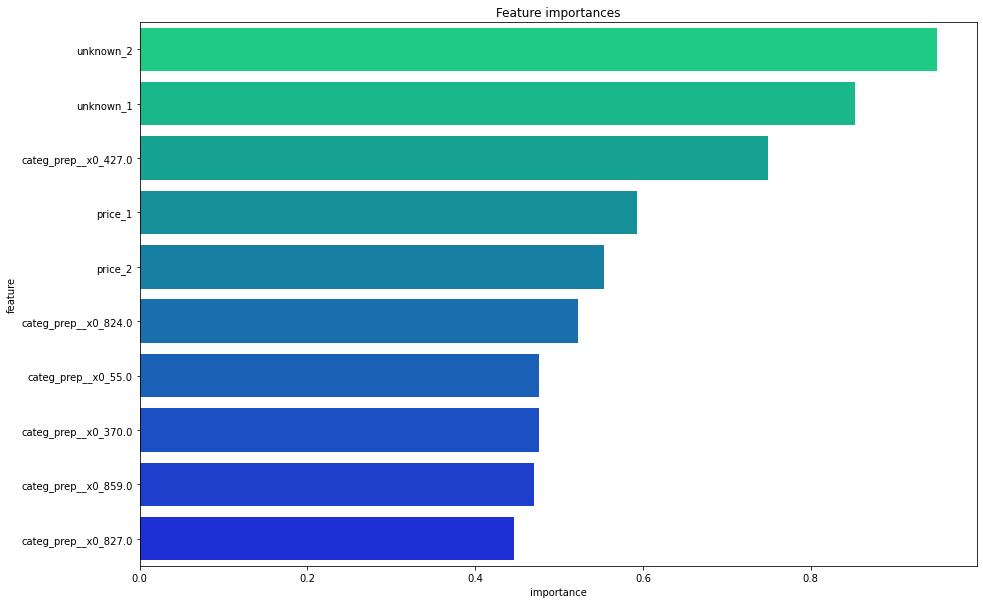

In [180]:
plt.figure(figsize=(15, 10))
sns.barplot(data=feature_importances[:10], x='importance', y='feature', palette="winter_r")
plt.title('Feature importances')
plt.show()

## Задание 11

Проделайте то же самое, но со случайным лесом.

In [59]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [60]:
y_pred = rf.predict(X_test)

precision_score(y_test, y_pred)

0.9478349465104432

In [61]:
N_users = np.unique(events_data['user_id']).shape[0]
user_cols = X_test.toarray()[:, :N_users]

pr = []
for i in range(N_users):
    ids = np.where(user_cols[:, i] == 1)[0]
    pr.append(precision_score(y_test.values[ids], y_pred[ids], zero_division=0))
    
print(np.mean(pr))

0.9430645894179938


In [62]:
pr = []
y_pred_prob = rf.predict_proba(X_test)[:, 1]

for i in range(N_users):
    ids = np.where(user_cols[:, i] == 1)[0]
    ps = y_pred_prob[ids]
    most_confident = ids[np.argsort(ps)[-3:]]
    
    pr.append(precision_score(y_test.values[most_confident], y_pred[most_confident], zero_division=0))
    
print(np.mean(pr))

0.9963296629963297


In [63]:
rf.feature_importances_

array([6.57457609e-04, 2.59180303e-04, 4.49601359e-04, ...,
       5.00313241e-02, 4.80385461e-02, 2.57600035e-05])

In [67]:
feature_importances = pd.DataFrame({'feature': column_transformer.get_feature_names(),
                                   'importance': rf.feature_importances_})
feature_importances

,feature,importance
0,categ_prep__x0_1.0,0.000657
1,categ_prep__x0_2.0,0.000259
2,categ_prep__x0_3.0,0.000450
3,categ_prep__x0_4.0,0.000501
4,categ_prep__x0_5.0,0.000149
...,...,...
1040,price_2,0.071113
1041,ratings_average_2,0.084037
1042,ratings_count_2,0.050031
1043,release_date_2,0.048039


In [68]:
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances.iloc[:10]

,feature,importance
1041,ratings_average_2,0.084037
1018,ratings_average_1,0.080886
1017,price_1,0.073704
1040,price_2,0.071113
1019,ratings_count_1,0.051030
1042,ratings_count_2,0.050031
1043,release_date_2,0.048039
1020,release_date_1,0.047002
1006,Drama_1,0.008259
1026,Comedy_2,0.008110


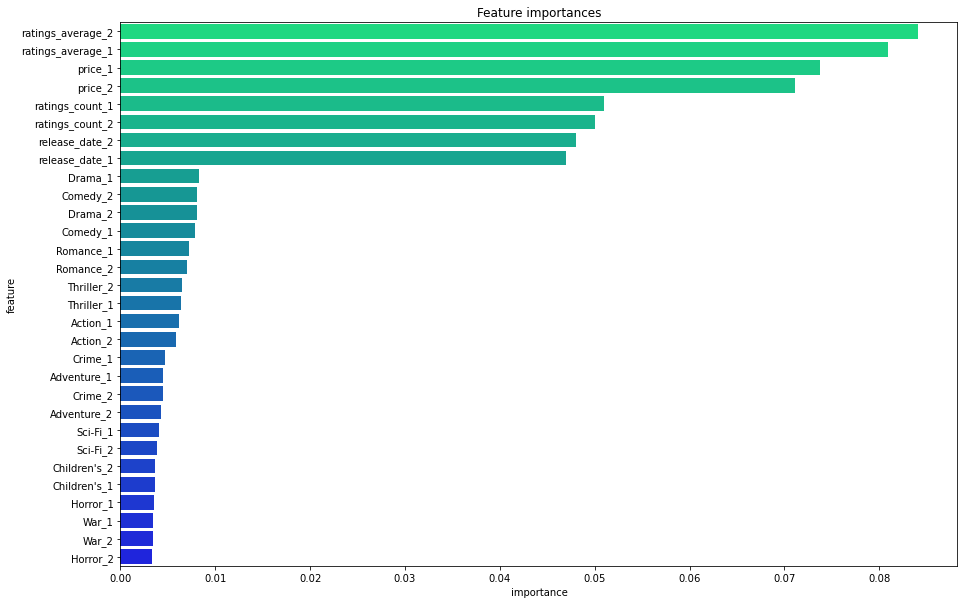

In [71]:
plt.figure(figsize=(15, 10))
sns.barplot(data=feature_importances[:30], x='importance', y='feature', palette="winter_r")
plt.title('Feature importances')
plt.show()

## Задание 12

Проделайте то же самое, но с градиентным бустингом.

In [ ]:
# your code here